In [12]:
import warnings
import numpy as np
import pandas as pd 
from sklearn.preprocessing import LabelEncoder
from src.wrapped import Wrapped
from src.analyses import *

# configurações

In [13]:
warnings.filterwarnings("ignore")
%matplotlib inline

wp = Wrapped(
    '../data/row/',
    '../data/processed/',
    '../data/files/'
)

# Importar dados

In [14]:
# dataset
df = wp.load_data('df_instrumentos_features_selecionadas').drop(columns=['file_name'])

# dataframes por instrumentos
inst_corda = ["cello", "guitar", "violin", "bass", "banjo", "mandolin", "ukulele"]
inst_percusao = ["mallet_percussion", "drums", "cymbals"]
inst_sopro = ["clarinet", "trombone", "flute", "trumpet", "saxophone"]
inst_aerofone = ["acordion", "organ", "piano"] 

# dataframes por classes de instrumentos
df_inst_aerofone_aerofone = df[df['instrumento'].isin(inst_aerofone)]
df_inst_aerofone_sopro = df[df['instrumento'].isin(inst_sopro)]
df_inst_aerofone_corda = df[df['instrumento'].isin(inst_corda)]
df_inst_aerofone_percusao = df[df['instrumento'].isin(inst_percusao)]

# Detecção de outilers 

In [16]:
pred_aerofone = detected_outilers(df_inst_aerofone_aerofone.drop(columns=['instrumento']))
pred_sopro = detected_outilers(df_inst_aerofone_sopro.drop(columns=['instrumento']))
pred_corda = detected_outilers(df_inst_aerofone_corda.drop(columns=['instrumento']))
pred_percusao = detected_outilers(df_inst_aerofone_percusao.drop(columns=['instrumento']))

### TSNE

- Instrumentos de Corda

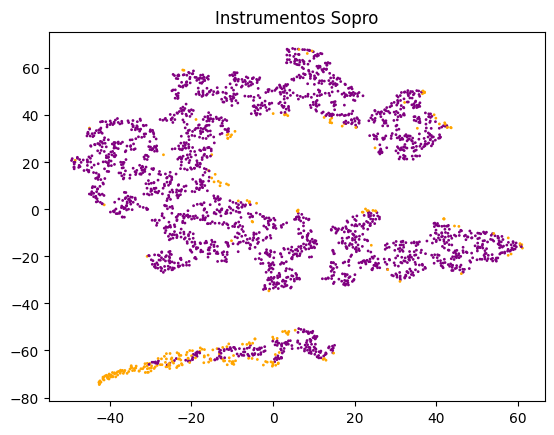

In [21]:
graphic_anomalies(df_inst_aerofone_corda.drop(columns=['instrumento']), 'Instrumentos Sopro')

- Instrumentos de Percusão

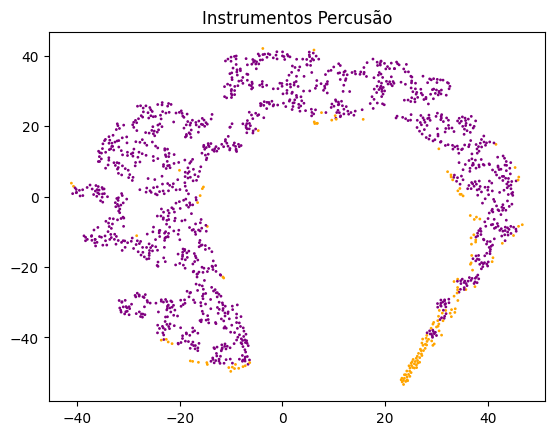

In [23]:
graphic_anomalies(df_inst_aerofone_percusao.drop(columns=['instrumento']), 'Instrumentos Percusão')

- Instrumentos de Sopro

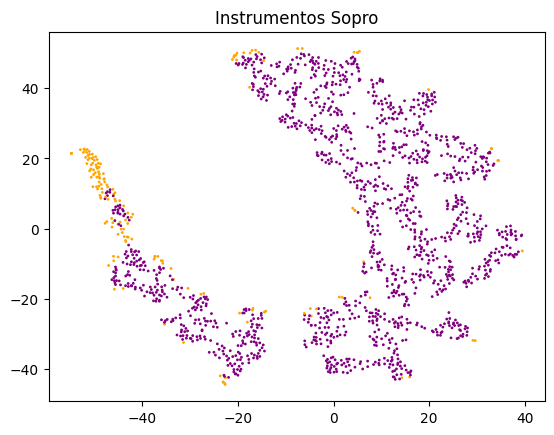

In [20]:
graphic_anomalies(df_inst_aerofone_sopro.drop(columns=['instrumento']), 'Instrumentos Sopro')

- Instrumentos de Aerofones

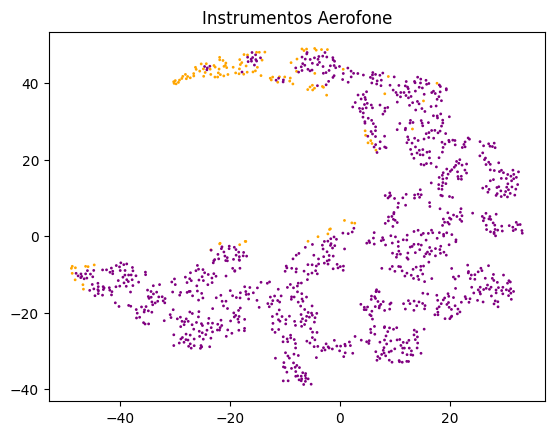

In [18]:
graphic_anomalies(df_inst_aerofone_aerofone.drop(columns=['instrumento']), 'Instrumentos Aerofone')